<a href="https://colab.research.google.com/github/Asigen93/DataMining_Prediksi_Wine/blob/main/perbandingan_prediksi_red_white.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [147]:
# 1. Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

In [149]:
# 2. Load dan gabungkan data
df_red = pd.read_csv('/content/redwine.csv', sep=';')
df_white = pd.read_csv('/content/whitewine.csv', sep=';')

In [150]:
df_red['type'] = 'red'
df_white['type'] = 'white'
df = pd.concat([df_red, df_white], ignore_index=True)

In [151]:
# Bersihkan spasi
df['alcohol'] = df['alcohol'].astype(str).str.strip()

# Cek unique values dulu supaya yakin
print("Contoh nilai unik kolom 'alcohol':")
print(df['alcohol'].unique()[:10])

# Hapus titik-titik yang dianggap pemisah ribuan
df['alcohol'] = df['alcohol'].str.replace('.', '', regex=False)

# Konversi ke numeric
df['alcohol'] = pd.to_numeric(df['alcohol'], errors='coerce')

# Tangani NaN jika ada
df['alcohol'] = df['alcohol'].fillna(df['alcohol'].median())

# Cek hasil konversi
print(df['alcohol'].dtype)

Contoh nilai unik kolom 'alcohol':
['9.4' '9.8' '10' '9.5' '10.5' '9.2' '9.9' '9.1' '9.3' '9']
int64


In [152]:
# 3. One-hot encoding kolom 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [153]:
# 4. Pisahkan fitur dan target
# Bersihkan spasi
df.columns = df.columns.str.strip()

# Cari nama kolom yang memuat 'quality'
quality_col = [col for col in df.columns if 'quality' in col.lower()]
print("Kolom target ditemukan:", quality_col)

# Pastikan ditemukan
if not quality_col:
    raise ValueError("Kolom target 'quality' tidak ditemukan di dataset!")

# Pisahkan fitur dan target
X = df.drop(quality_col, axis=1)
y = df[quality_col[0]]

Kolom target ditemukan: ['quality']


In [154]:
# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.15,
    random_state=42
)

In [155]:
# Dictionary berisi kedua model
models = {
    "Random Forest Regressor": rf_model,
    "XGBoost Regressor": xgb_model
}

In [156]:
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    })

results_df = pd.DataFrame(results)
print(results_df)

                     Model       MAE      RMSE        R2
0  Random Forest Regressor  0.160612  0.245449  0.898676
1        XGBoost Regressor  0.039096  0.160216  0.956828


In [157]:
# Ambil importance dari Random Forest
rf_importance = rf_model.feature_importances_
rf_df = pd.DataFrame({
    'Fitur': X.columns,
    'Importance': rf_importance,
    'Model': 'Random Forest'
})

# Ambil importance dari XGBoost
xgb_importance = xgb_model.feature_importances_
xgb_df = pd.DataFrame({
    'Fitur': X.columns,
    'Importance': xgb_importance,
    'Model': 'XGBoost'
})

# Gabungkan keduanya
importance_df = pd.concat([rf_df, xgb_df])


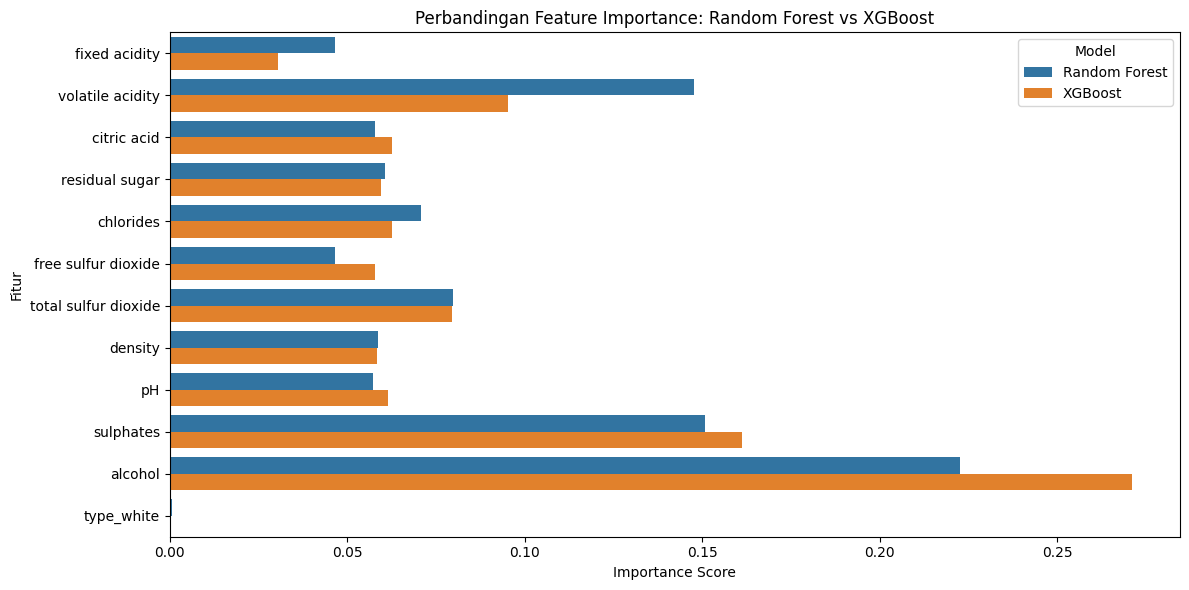

In [158]:
# Plot side-by-side barplot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=importance_df,
    x='Importance',
    y='Fitur',
    hue='Model',
    orient='h'
)
plt.title('Perbandingan Feature Importance: Random Forest vs XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Fitur')
plt.legend(title='Model')
plt.tight_layout()
plt.show()


/tmp/ipython-input-159-1897231553.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


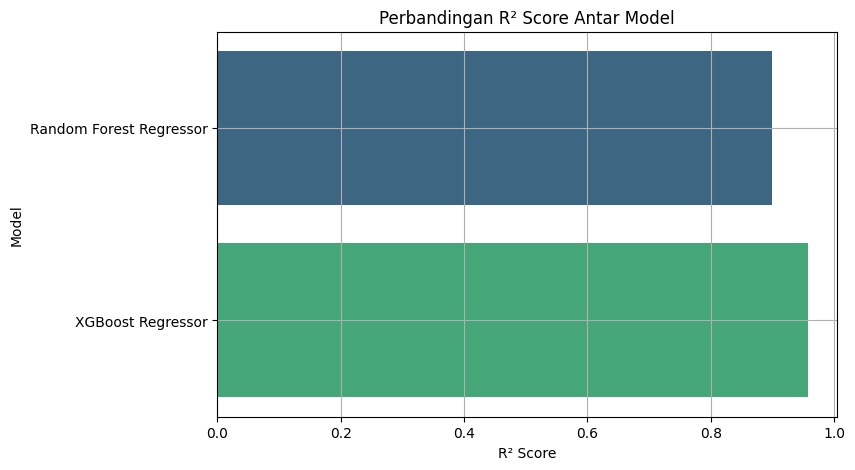

In [159]:
# 8. Visualisasi R2 per model
plt.figure(figsize=(8, 5))
sns.barplot(
    x='R2',
    y='Model',
    data=results_df.sort_values(by='R2', ascending=True),
    palette='viridis'
)
plt.title('Perbandingan R² Score Antar Model')
plt.xlabel('R² Score')
plt.ylabel('Model')
plt.grid(True)
plt.show()

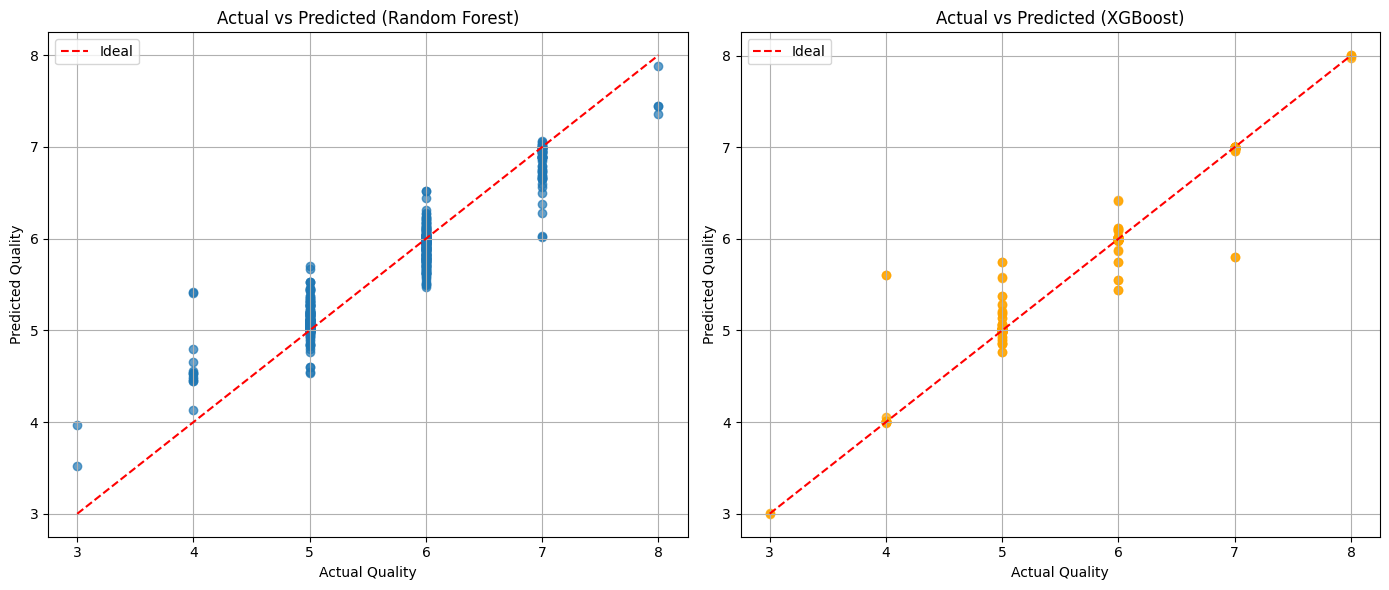

In [163]:
# Prediksi
y_pred_rf = rf_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)

# Buat figure dengan 2 subplot horizontal
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].scatter(y_test, y_pred_rf, alpha=0.7)
axes[0].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    label="Ideal"
)
axes[0].set_title("Actual vs Predicted (Random Forest)")
axes[0].set_xlabel("Actual Quality")
axes[0].set_ylabel("Predicted Quality")
axes[0].legend()
axes[0].grid(True)

# XGBoost
axes[1].scatter(y_test, y_pred_xgb, alpha=0.7, color="orange")
axes[1].plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--',
    label="Ideal"
)
axes[1].set_title("Actual vs Predicted (XGBoost)")
axes[1].set_xlabel("Actual Quality")
axes[1].set_ylabel("Predicted Quality")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


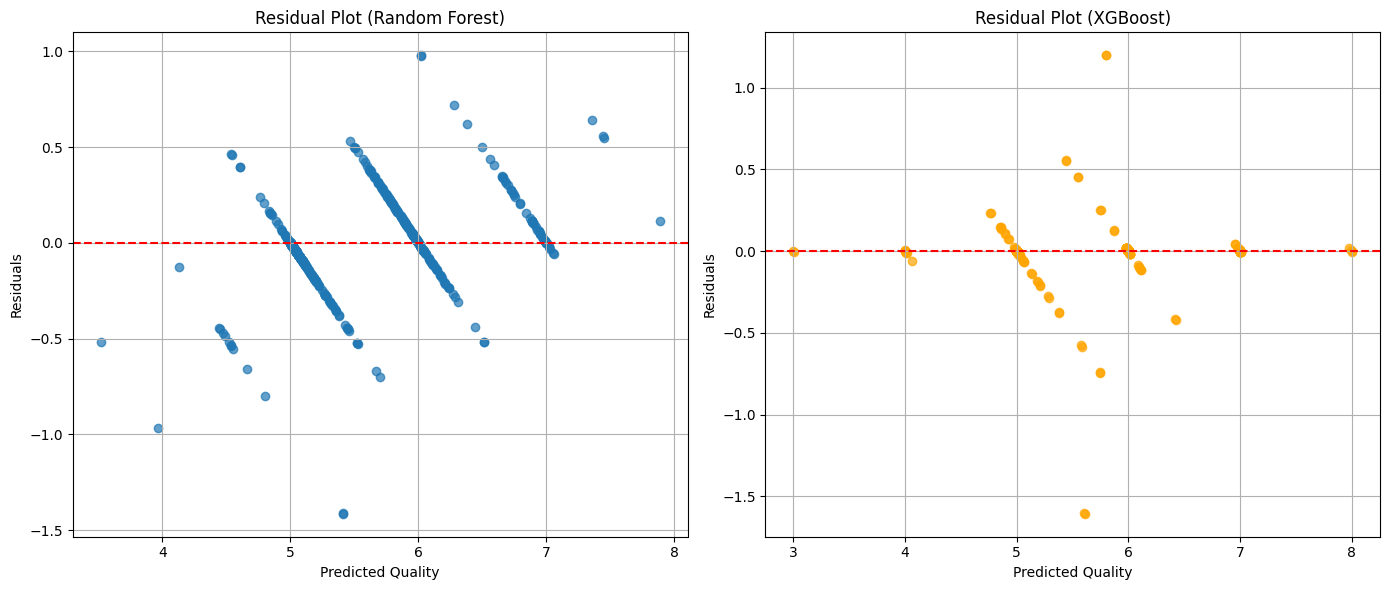

In [164]:
# Hitung residuals
residuals_rf = y_test - y_pred_rf
residuals_xgb = y_test - y_pred_xgb

# Buat figure dengan 2 subplot horizontal
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
axes[0].scatter(y_pred_rf, residuals_rf, alpha=0.7)
axes[0].axhline(y=0, color='r', linestyle='--')
axes[0].set_title("Residual Plot (Random Forest)")
axes[0].set_xlabel("Predicted Quality")
axes[0].set_ylabel("Residuals")
axes[0].grid(True)

# XGBoost
axes[1].scatter(y_pred_xgb, residuals_xgb, alpha=0.7, color="orange")
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_title("Residual Plot (XGBoost)")
axes[1].set_xlabel("Predicted Quality")
axes[1].set_ylabel("Residuals")
axes[1].grid(True)

plt.tight_layout()
plt.show()

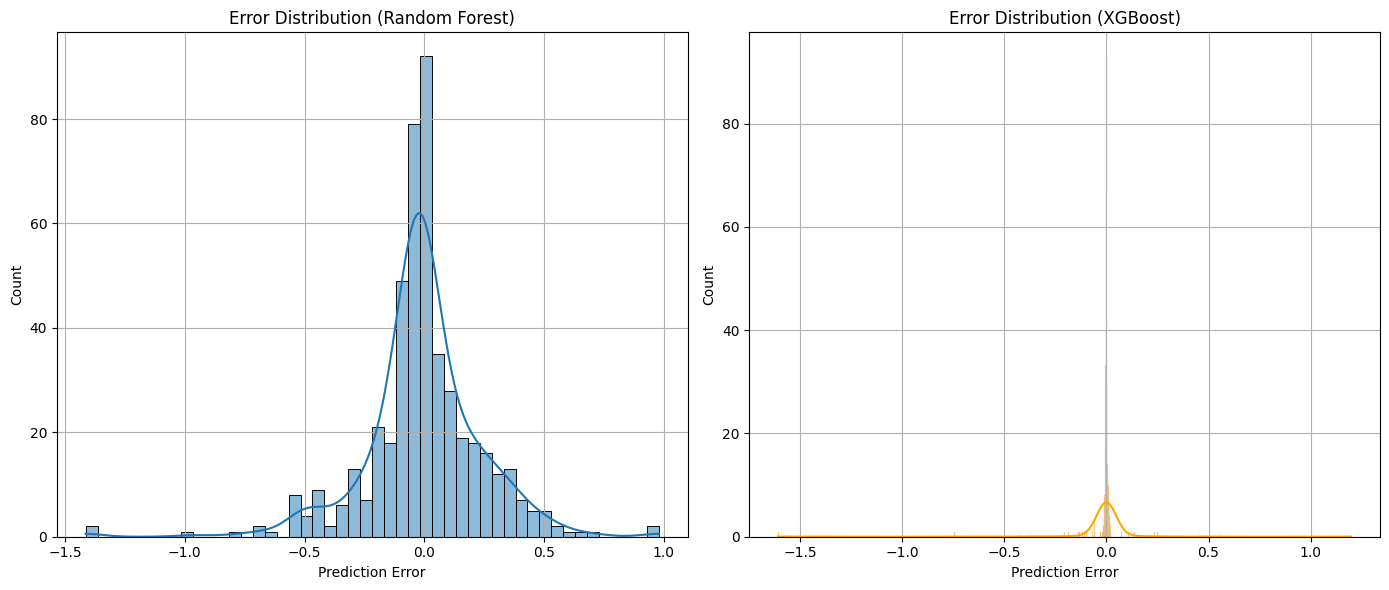

In [165]:
# Buat figure dengan 2 subplot horizontal
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest
sns.histplot(residuals_rf, kde=True, ax=axes[0])
axes[0].set_title("Error Distribution (Random Forest)")
axes[0].set_xlabel("Prediction Error")
axes[0].grid(True)

# XGBoost
sns.histplot(residuals_xgb, kde=True, color="orange", ax=axes[1])
axes[1].set_title("Error Distribution (XGBoost)")
axes[1].set_xlabel("Prediction Error")
axes[1].grid(True)

plt.tight_layout()
plt.show()